In [6]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import dask.dataframe as dd
import dask
from dask import delayed
from dask.diagnostics import ProgressBar
from dask.multiprocessing import get
from sklearn.preprocessing import normalize

from scipy.spatial.distance import cosine, mahalanobis, cdist
from sklearn.metrics import roc_curve, precision_score
from scipy.sparse import csr_matrix
from scipy.stats import entropy
from scipy.optimize import minimize 

VEC_DIM = 400

FILE_DIR = "/work4/tzy/spk_verify_backend/exp_dvectors/" #folder where all files are located
!ls /work4/tzy/spk_verify_backend/exp_dvectors

enroll.ark  enroll.spk2utt  test.ark  test.spk2utt  trials


In [2]:
def run_test(score_func, sample_size = 0.10, ESPK = 0, TSPK = 0, n_features = 1, dask_array = False, pairs=None):

    def score_vectors(x):
        """
        enroll_id: ID of enrolled speaker 
        test_id: ID of a test speaker
        enroll_spk: Dataframe of enroll speakers and processed utterance vectors 
        test_spk: As enroll_spk
        score_func: scoring function that takes 2 speakers' data and produces a score
        """
        enroll_data = ESPK.loc[x['enroll']] # Pandas series
        test_data = TSPK.loc[x['test_id']]
        res = score_func(enroll_data, test_data)
        return res

    dask_pairs = dd.from_pandas(pairs, npartitions=16).sample(frac= sample_size, random_state=1)
    #dask_pairs = dd.from_pandas(pairs, npartitions=16)
    meta = ('x','f8')

    scores = 0
    
    pbar = ProgressBar()
    pbar.register()
    scores = dask_pairs.map_partitions(lambda df: df.apply(score_vectors ,axis=1), meta=meta)
    
    #New impl returns data in stacked format and takes 1/3 time
    if n_features>1: # This conditional halves the time if n_features==1
        scores = dask.array.from_delayed(delayed(np.vstack)(scores.values), shape=(len(dask_pairs), n_features), dtype='float64')
        scores = scores.rechunk((1000,500))
    res =  dask.array.from_array(np.array(dask_pairs['result']), (1000,))
    #res.rechunk((1000,500))
    if dask_array:
        pbar.unregister()
        return scores, res
    
    #scores = scores if delayed_res else scores.compute() #Turns out it is faster to do dd.compute(*(scores.compute())) if the inner func produces delayed objs
    scores = scores.compute(get=get)
    res = res.compute()
    pbar.unregister()
    
    return scores, res

def calcEER(series, true, name = ""):
    fpr, tpr, thresholds = roc_curve(true, series)
    plt.plot(fpr, tpr)
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    fnr = 1 - tpr
    minPt = np.nanargmin(np.absolute((fnr - fpr)))
    print("Threshold: ", thresholds[minPt])
    print("EER/FPR: ", fpr[minPt])
    print("FNR: ", fnr[minPt])
    
    if name:
        plt.savefig(name)
    
    return

def read_trials(filename):
    pairs = pd.read_table(FILE_DIR+filename, names = ["enroll","test_id","result"], sep = " ") 
    print("num of trials: ",len(pairs))

    # Encode "nontarget" as 0, "target as 1"
    pairs['result'].replace({"nontarget":0, "target":1}, inplace = True)
    print(pairs.head())
    return pairs

def read_spk2utt_utts(filename):  
    """Processes the utterance vectors for each speaker
        filename: name of spk2utt file
        ark_df: corresponding ark file"""
    df = pd.read_table(FILE_DIR+filename, names = ['id', 'utt1', 'utt2','utt3','utt4','utt5'], sep = " ") 
    df.dropna(axis=1, inplace=True)
    df.index = df['id']
    df = df.drop('id', 1)
    return df 

def cos_similarity(vect1, vect2):
    return 1 - cosine(vect1, vect2)

def getVar(dist1, dist2):
    var = np.var(dist1.values, axis=0)
    return np.mean(var)

# takes spkr from raw, test from spk, and returns a single value
def zscore_col(spkr, test):
    std = np.std(spkr, axis=0)
    scores = np.absolute(np.divide((test-spkr.mean(axis=0)), np.where(std!=0, std, 0.0000001)) )
    res = np.median(scores)
    return res

# def zscore_col_delayed(spkr, test):
#     std = delayed(np.std)(spkr, axis=0)
#     scores = delayed(np.absolute)(delayed(np.divide)(test - spkr.mean(axis=0), delayed(np.where)(std!=0, std, 0.0000001)))
#     res = delayed(np.median)(scores)
#     return res

# Calculate FPR and FNR with variable thresholds for scores
# Takes predictions and results 
def calcFR(pred, true):
    fpr = pred[(pred==1) & (true==0)].sum()/(true==0).sum()
    fnr = true[(pred==0) & (true==1)].sum()/(true==1).sum()
    print("FPR: ", fpr)
    print("FNR: ", fnr)
    
def sendScores(scores, res, name):
    pd.DataFrame(data=np.vstack((scores, res))).to_hdf("scores.h5", name)
    
def showH5(filename):
    with pd.HDFStore(filename) as store:
        print(store.keys())

In [3]:
# Load spk data from h5
enroll_spk = pd.read_hdf('spk.h5', 'enroll')
test_spk = pd.read_hdf('spk.h5', 'test')
enroll_spk_raw = pd.read_hdf('spk_raw.h5', 'enroll_raw')
test_spk_raw = pd.read_hdf('spk_raw.h5', 'test_raw')

In [249]:
showH5('samp.h5')

['/enroll_ark_samp_tenth', '/enroll_ark_samp_tenth_spkrs', '/pairs_samp_100k', '/test_ark_samp_tenth', '/test_ark_samp_tenth_spkrs']


In [250]:
enroll_ark_samp = pd.read_hdf('samp.h5', 'enroll_ark_samp_tenth')
test_ark_samp = pd.read_hdf('samp.h5', 'test_ark_samp_tenth')


In [252]:
enroll_utts = read_spk2utt_utts('enroll.spk2utt')
test_utts = read_spk2utt_utts('test.spk2utt')

In [260]:
pairs_samp = pd.read_hdf('samp.h5', 'pairs_samp_100k')

In [5]:
pairs = read_trials('trials')

num of trials:  11725308
       enroll          test_id  result
0  4780420411  fc_4779547143_0       0
1  4780420411  fc_4779547143_1       0
2  4780420411  fc_4779547143_2       0
3  4780420411  fc_4779547143_3       0
4  4780420411  fc_4779547143_4       0


In [261]:
pairs_samp.head()

,enroll,test_id,result
51449,4780176039,fc_4779876202_1,0
51452,4780176039,fc_4779876202_4,0
51469,4780176039,fc_4777209389_0,0
51507,4780176039,fc_4777329354_7,0
51519,4780176039,fc_4777418300_0,0


In [211]:
spkr, test = enroll_ark_samp.loc[4780420411], test_spk_raw.loc['fc_4779547143_0']

In [267]:
enroll_ark_samp.loc[enroll_utts.loc[4780176039].values].values.shape

(569, 400)

In [288]:
# also think about length normalization
def md_frame(spkr_utts, test):
    # pool all spkr d-vecs together
    s = enroll_ark_samp.loc[spkr_utts.values].values
    c = np.cov(s.T)
    return mahalanobis(s.mean(axis=0), test, np.linalg.pinv(c) )

In [287]:
md_frame(enroll_utts.loc[4780176039], test_spk.loc['fc_4779876202_1'])

620.9250764596275

In [289]:
md_scores, res = run_test(md_frame, 0.1, enroll_utts, test_spk, pairs = pairs_samp)

[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  9min 13.2s
[########################################] | 100% Completed |  9min 13.3s
[########################################] | 100% Completed |  9min 13.4s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.2s
[########################################] | 100% Completed |  0.2s


Threshold:  347.2988798722079
EER/FPR:  0.46154726482032504
FNR:  0.4444444444444444


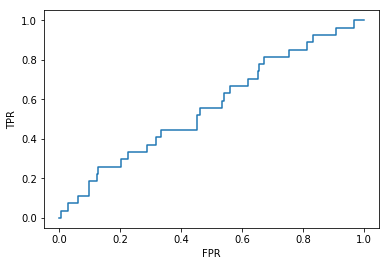

In [290]:
calcEER(md_scores, res)

In [247]:
def md_cut(spkr, test):
    c = np.cov(spkr.values.T)
    #print(c)
    return (mahalanobis(spkr.values[0], test.values[0], np.linalg.inv(c)))

In [248]:
md_cut(spkr, test)

1017617876.8853925

In [166]:
np.linalg.inv(np.cov(spkr[:3].T))

array([[ 2.31805299e+19, -1.87867258e+18,  7.38062716e+17, ...,
        -1.43655028e+19, -3.45502433e+19, -1.29501456e+19],
       [ 2.42093746e+19,  2.33708189e+18, -4.47982548e+18, ...,
         4.88036979e+16,  8.34247192e+18,  5.25009689e+18],
       [-1.74058593e+18, -6.56113468e+18, -4.82235055e+18, ...,
         4.10719194e+18, -1.89547593e+19, -7.58319976e+18],
       ...,
       [ 1.55782522e+19,  6.67990892e+18, -6.69738819e+18, ...,
        -1.05748036e+18,  1.57821922e+19,  1.07948367e+19],
       [-5.00547259e+18, -7.06273651e+18,  8.16058053e+17, ...,
         3.00105405e+18, -2.93823039e+19, -2.39906286e+18],
       [-5.48423320e+17, -1.56841411e+18,  1.26922828e+18, ...,
        -1.22466697e+18, -2.46847943e+18, -3.65477805e+18]])

In [203]:
def md(spkr, test):
    #d = cdist(spkr.T, test.T, 'mahalanobis', VI= np.linalg.inv(np.cov(spkr[:3].T)))
    d = cdist(spkr, test, 'mahalanobis', VI= None)
    return d.mean(axis=0).mean()

In [150]:
md_scores, res = run_test(md, 0.01, enroll_spk_raw, test_spk_raw, pairs = pairs)

[########################################] | 100% Completed |  0.4s
[########################################] | 100% Completed |  0.5s
[########################################] | 100% Completed |  5min 12.4s
[########################################] | 100% Completed |  5min 12.5s
[########################################] | 100% Completed |  0.1s
[########################################] | 100% Completed |  0.1s


Threshold:  2.285357065532386
EER/FPR:  0.50281916347731
FNR:  0.5


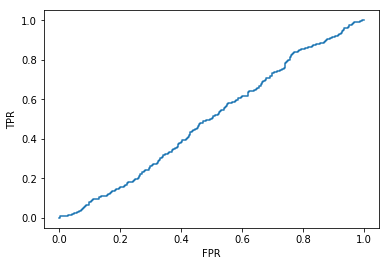

In [152]:
calcEER(md_scores, res)

(array([7.1443e+04, 3.5993e+04, 7.6370e+03, 1.6020e+03, 4.0600e+02,
        1.0400e+02, 3.2000e+01, 1.8000e+01, 6.0000e+00, 7.0000e+00]),
 array([1.84355687, 2.37362727, 2.90369767, 3.43376807, 3.96383847,
        4.49390887, 5.02397927, 5.55404967, 6.08412007, 6.61419047,
        7.14426087]),
 <a list of 10 Patch objects>)

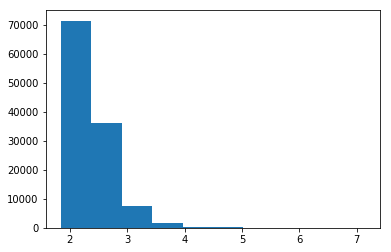

In [158]:
plt.hist(md_scores)

(array([58., 76., 35., 13.,  7.,  1.,  0.,  0.,  0.,  2.]),
 array([1.93138171, 2.17854349, 2.42570527, 2.67286705, 2.92002882,
        3.1671906 , 3.41435238, 3.66151416, 3.90867593, 4.15583771,
        4.40299949]),
 <a list of 10 Patch objects>)

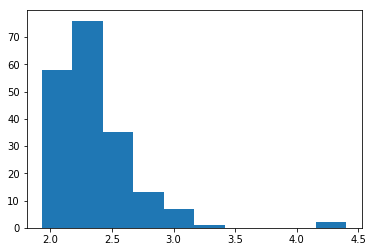

In [159]:
plt.hist(md_scores[res==1])

# Conclusion: Mahalanobis distance can be implemented in a number of ways but these trials were unsuccessful - need more work